# Environment Setup

In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark as snp
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
import snowflake.snowpark.window as W

import pandas as pd
import json

from snowflake.ml.modeling.lightgbm import LGBMClassifier
from snowflake.ml.modeling.metrics import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Create Snowpark Session

In [2]:
# Make a Snowpark Connection
# Edit the connection.json before creating the session object below
# Create Snowflake Session object

connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.custom_package_usage_config = {"enabled": True}
session.add_packages(["numpy==1.26.3"])

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Parameter custom_package_usage_config is experimental since 1.6.0. Do not use it in production. 
The following packages are not available in Snowflake: ['numpy==1.26.3'].
If you are adding package(s) unavailable in Snowflake, it is highly recommended that you include the 'cache_path' configuration parameter in order to reduce latency.
Package numpy(version 1.26.3) contains native code, switching to latest available version in Snowflake instead.



Connection Established with the following parameters:
User                        : JOHN
Role                        : "ACCOUNTADMIN"
Database                    : "SCORED_MODEL"
Schema                      : "SCORED_MODEL"
Warehouse                   : "QUERY_WH"
Snowflake version           : 8.0.0
Snowpark for Python version : 1.11.1


## Feature Engineering

This notebook is based on the worksheet found here (https://www.kaggle.com/code/ambrosm/amex-lightgbm-quickstart), with some modifications. The dataset has multople values per customer ID, so we will undertake some feature engineering to find the mean, standard deviation, min, max and last values of each customer ID, so we have features and customer ID as a unique key.

In [3]:
#Create Snowpark df from shared data
training_df = session.table('cc_default_training_data')

In [4]:
# Check number of rows (5,531,451 rows)
training_df.count()

5531451

In [5]:
# Check first 5 rows
training_df.show(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
training_df.columns

['S_2',
 'P_2',
 'D_39',
 'B_1',
 'B_2',
 'R_1',
 'S_3',
 'D_41',
 'B_3',
 'D_42',
 'D_43',
 'D_44',
 'B_4',
 'D_45',
 'B_5',
 'R_2',
 'D_46',
 'D_47',
 'D_48',
 'D_49',
 'B_6',
 'B_7',
 'B_8',
 'D_50',
 'D_51',
 'B_9',
 'R_3',
 'D_52',
 'P_3',
 'B_10',
 'D_53',
 'S_5',
 'B_11',
 'S_6',
 'D_54',
 'R_4',
 'S_7',
 'B_12',
 'S_8',
 'D_55',
 'D_56',
 'B_13',
 'R_5',
 'D_58',
 'S_9',
 'B_14',
 'D_59',
 'D_60',
 'D_61',
 'B_15',
 'S_11',
 'D_62',
 'D_63',
 'D_64',
 'D_65',
 'B_16',
 'B_17',
 'B_18',
 'B_19',
 'D_66',
 'B_20',
 'D_68',
 'S_12',
 'R_6',
 'S_13',
 'B_21',
 'D_69',
 'B_22',
 'D_70',
 'D_71',
 'D_72',
 'S_15',
 'B_23',
 'D_73',
 'P_4',
 'D_74',
 'D_75',
 'D_76',
 'B_24',
 'R_7',
 'D_77',
 'B_25',
 'B_26',
 'D_78',
 'D_79',
 'R_8',
 'R_9',
 'S_16',
 'D_80',
 'R_10',
 'R_11',
 'B_27',
 'D_81',
 'D_82',
 'S_17',
 'R_12',
 'B_28',
 'R_13',
 'D_83',
 'R_14',
 'R_15',
 'D_84',
 'R_16',
 'B_29',
 'B_30',
 'S_18',
 'D_86',
 'D_87',
 'R_17',
 'R_18',
 'D_88',
 'B_31',
 'S_19',
 'R_19',
 '

For the next section, we are going to perform feature engineering create three groups of features:
- Selected features averaged over all statements of a customer
- The minimum or maximum of selected features over all statements of a customer
- Selected features taken from the last statement of a customer

In [7]:
# The following cells create the average numerical values for selected features per customer
features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']

In [8]:
feat = [F.col(c) for c in features_avg]

In [9]:
exprs = {x: "avg" for x in features_avg}

In [10]:
df_avg = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs)
          .rename({F.col(f"AVG({f})"): f"{f}_avg" for f in features_avg})
         )

In [11]:
df_avg.count()

458913

In [12]:
# The following cells create the minimum numerical values for selected features per customer
features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']

In [13]:
exprs_min = {x: "min" for x in features_min}

In [14]:
df_min = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs_min)
          .rename({F.col(f"MIN({f})"): f"{f}_min" for f in features_min})
         )

In [15]:
df_min.count()

458913

In [16]:
# The following cells create the maximum numerical values for selected features per customer
features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']

In [17]:
exprs_max = {x: "max" for x in features_max}

In [18]:
df_max = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs_max)
          .rename({F.col(f"MAX({f})"): f"{f}_max" for f in features_max})
         )

In [19]:
df_max.count()

458913

In [20]:
# The following cells create the last numerical values for selected features per customer, with S_2 being the date field.
features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', '"customer_ID"', '"target"']

In [21]:
w = snp.Window.partition_by('"customer_ID"').order_by(F.col('S_2').desc())

In [22]:
df_last = training_df.withColumn("rn", F.row_number().over(w)).filter("rn = 1").select(features_last)

In [23]:
df_last.count()

458913

In [24]:
# Now we join these dataframes on customer ID
feature_df = df_min.natural_join(df_avg)

In [25]:
feature_df = feature_df.natural_join(df_max)

In [26]:
feature_df = feature_df.natural_join(df_last)

In [27]:
feature_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
# Split the data into train and test sets
train_df, test_df = feature_df.random_split(weights=[0.9, 0.1], seed=0)

In [29]:
print((feature_df.count(), len(feature_df.columns)))
print((train_df.count(), len(train_df.columns)))
print((test_df.count(), len(test_df.columns)))

(458913, 471)
(413064, 471)
(45849, 471)


In [30]:
feature_cols = feature_df.columns
feature_cols

['"customer_ID"',
 'B_2_MIN',
 'B_4_MIN',
 'B_5_MIN',
 'B_9_MIN',
 'B_13_MIN',
 'B_14_MIN',
 'B_15_MIN',
 'B_16_MIN',
 'B_17_MIN',
 'B_19_MIN',
 'B_20_MIN',
 'B_28_MIN',
 'B_29_MIN',
 'B_33_MIN',
 'B_36_MIN',
 'B_42_MIN',
 'D_39_MIN',
 'D_41_MIN',
 'D_42_MIN',
 'D_45_MIN',
 'D_46_MIN',
 'D_48_MIN',
 'D_50_MIN',
 'D_51_MIN',
 'D_53_MIN',
 'D_55_MIN',
 'D_56_MIN',
 'D_58_MIN',
 'D_59_MIN',
 'D_60_MIN',
 'D_62_MIN',
 'D_70_MIN',
 'D_71_MIN',
 'D_74_MIN',
 'D_75_MIN',
 'D_78_MIN',
 'D_83_MIN',
 'D_102_MIN',
 'D_112_MIN',
 'D_113_MIN',
 'D_115_MIN',
 'D_118_MIN',
 'D_119_MIN',
 'D_121_MIN',
 'D_122_MIN',
 'D_128_MIN',
 'D_132_MIN',
 'D_140_MIN',
 'D_141_MIN',
 'D_144_MIN',
 'D_145_MIN',
 'P_2_MIN',
 'P_3_MIN',
 'R_1_MIN',
 'R_27_MIN',
 'S_3_MIN',
 'S_5_MIN',
 'S_7_MIN',
 'S_9_MIN',
 'S_11_MIN',
 'S_12_MIN',
 'S_23_MIN',
 'S_25_MIN',
 'B_1_AVG',
 'B_2_AVG',
 'B_3_AVG',
 'B_4_AVG',
 'B_5_AVG',
 'B_6_AVG',
 'B_8_AVG',
 'B_9_AVG',
 'B_10_AVG',
 'B_11_AVG',
 'B_12_AVG',
 'B_13_AVG',
 'B_14_AVG',

In [42]:
feature_df.schema.fields

[StructField('"customer_ID"', StringType(16777216), nullable=True),
 StructField('B_2_MIN', DoubleType(), nullable=True),
 StructField('B_4_MIN', DoubleType(), nullable=True),
 StructField('B_5_MIN', DoubleType(), nullable=True),
 StructField('B_9_MIN', DoubleType(), nullable=True),
 StructField('B_13_MIN', DoubleType(), nullable=True),
 StructField('B_14_MIN', DoubleType(), nullable=True),
 StructField('B_15_MIN', DoubleType(), nullable=True),
 StructField('B_16_MIN', DoubleType(), nullable=True),
 StructField('B_17_MIN', DoubleType(), nullable=True),
 StructField('B_19_MIN', DoubleType(), nullable=True),
 StructField('B_20_MIN', DoubleType(), nullable=True),
 StructField('B_28_MIN', DoubleType(), nullable=True),
 StructField('B_29_MIN', DoubleType(), nullable=True),
 StructField('B_33_MIN', LongType(), nullable=True),
 StructField('B_36_MIN', LongType(), nullable=True),
 StructField('B_42_MIN', DoubleType(), nullable=True),
 StructField('D_39_MIN', DoubleType(), nullable=True),
 Stru

In [31]:
feature_cols = feature_df.columns
feature_cols.remove('"target"')
feature_cols.remove('"customer_ID"')
target_col = '"target"'

In [32]:
session.sql("CREATE DATABASE IF NOT EXISTS SCORED_MODEL").collect()

[Row(status='SCORED_MODEL already exists, statement succeeded.')]

In [33]:
session.sql("USE DATABASE SCORED_MODEL").collect()

[Row(status='Statement executed successfully.')]

In [34]:
session.sql("CREATE SCHEMA IF NOT EXISTS SCORED_MODEL").collect()

[Row(status='SCORED_MODEL already exists, statement succeeded.')]

In [35]:
session.sql("USE SCHEMA SCORED_MODEL").collect()

[Row(status='Statement executed successfully.')]

In [36]:
session.sql("USE WAREHOUSE TRAINING_WH").collect()

[Row(status='Statement executed successfully.')]

In [37]:
lgbmodel = LGBMClassifier(
    input_cols=feature_cols, 
    label_cols=target_col, 
    output_cols='PREDICTION'
    )
lgbmodel.fit(train_df)

/Users/tbuchhorn/opt/anaconda3/envs/pysnowpark1/lib/python3.10/site-packages/snowflake/ml/_internal/utils/snowpark_dataframe_utils.py:88: UserWarning: Warning: The Decimal(38, 6) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  warnings.warn(
The version of package 'snowflake-snowpark-python' in the local environment is 1.11.1, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.
The following packages are not available in Snowflake: ['numpy==1.26.3'].
If you are adding package(s) unavailable in Snowflake, it is highly recommended that you include the 'cache_path' configuration parameter in order to reduce latency.
Package numpy(v

In [38]:
lgbmodel_local = lgbmodel.to_lightgbm()

<Axes: >

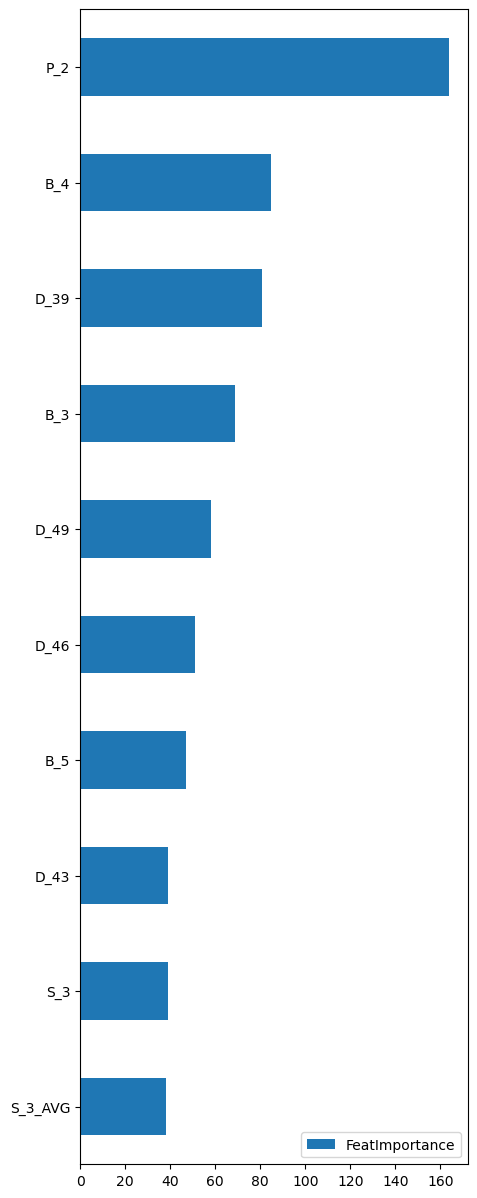

In [39]:
# Plot feature importance
feat_importance = pd.DataFrame(lgbmodel_local.feature_importances_,lgbmodel_local.feature_name_,columns=['FeatImportance'])
feat_importance.sort_values('FeatImportance').tail(10).plot.barh(y='FeatImportance', figsize=(5,15))

In [44]:
test_df.dropna().show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
test_df.schema.fields

[StructField('"customer_ID"', StringType(16777216), nullable=True),
 StructField('B_2_MIN', DoubleType(), nullable=True),
 StructField('B_4_MIN', DoubleType(), nullable=True),
 StructField('B_5_MIN', DoubleType(), nullable=True),
 StructField('B_9_MIN', DoubleType(), nullable=True),
 StructField('B_13_MIN', DoubleType(), nullable=True),
 StructField('B_14_MIN', DoubleType(), nullable=True),
 StructField('B_15_MIN', DoubleType(), nullable=True),
 StructField('B_16_MIN', DoubleType(), nullable=True),
 StructField('B_17_MIN', DoubleType(), nullable=True),
 StructField('B_19_MIN', DoubleType(), nullable=True),
 StructField('B_20_MIN', DoubleType(), nullable=True),
 StructField('B_28_MIN', DoubleType(), nullable=True),
 StructField('B_29_MIN', DoubleType(), nullable=True),
 StructField('B_33_MIN', LongType(), nullable=True),
 StructField('B_36_MIN', LongType(), nullable=True),
 StructField('B_42_MIN', DoubleType(), nullable=True),
 StructField('D_39_MIN', DoubleType(), nullable=True),
 Stru

In [56]:
scored_df = lgbmodel.predict(test_df.fillna(0.0))
scored_df.write.save_as_table(table_name='CC_DEFAULT_RISK_TEST_SCORED', mode='overwrite')
session.table('CC_DEFAULT_RISK_TEST_SCORED').show()

Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "customer_ID", Type: StringType(16777216), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "B_33_MIN", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "B_36_MIN", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_112_MIN", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_128_MIN", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_140_MIN", Type

Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_128_MAX", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_135_MAX", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_140_MAX", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "R_17_MAX", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "R_27_MAX", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "B_8", Type: LongType(), Inpu

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [55]:
scored_df.columns

['D_42_MIN',
 'D_126_AVG',
 'D_115_AVG',
 'D_106',
 'D_132',
 'R_11_AVG',
 'D_64',
 'B_1_AVG',
 'D_71_MAX',
 'R_3',
 'D_74_MIN',
 'D_130',
 'D_125_MAX',
 'R_11',
 'D_111_MAX',
 'D_138_MAX',
 'B_32',
 'D_91_AVG',
 'B_33_AVG',
 'R_15_AVG',
 'P_4_AVG',
 'D_77',
 'R_1',
 'D_119_MIN',
 'R_7_AVG',
 'D_113_MIN',
 'D_102_MAX',
 'D_63_MAX',
 'D_79',
 'D_63',
 'D_77_MAX',
 'D_48',
 'B_19_MIN',
 'B_29',
 'D_134',
 'R_1_AVG',
 'D_140_MAX',
 'D_54_AVG',
 'D_133',
 'S_19',
 'D_53_AVG',
 'B_40_AVG',
 'D_58_MAX',
 'D_74_AVG',
 'B_18_AVG',
 'R_9_AVG',
 'B_40',
 'D_142_MAX',
 'D_72_AVG',
 'D_117_MAX',
 'D_118_MAX',
 'S_24_MAX',
 'D_116_MAX',
 'B_37_MAX',
 'D_92_AVG',
 'D_39',
 'P_2_AVG',
 'D_45_MAX',
 'D_115_MIN',
 'B_3_MAX',
 'S_12_AVG',
 'D_141_AVG',
 'R_4',
 'D_49',
 'R_6_MAX',
 'B_39_AVG',
 'R_17_AVG',
 'D_72',
 'D_43_AVG',
 'D_73_AVG',
 'S_23_MAX',
 'D_50_AVG',
 'B_28_AVG',
 'B_19_MAX',
 'D_78_AVG',
 'D_145_MIN',
 'D_58',
 'S_9_MIN',
 'D_53_MIN',
 'D_62_MIN',
 'B_38_AVG',
 'B_1',
 'D_76_MAX',
 'D_4

In [57]:
print('Acccuracy:', accuracy_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('Precision:', precision_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('Recall:', recall_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('F1:', f1_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))

# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_df, y_true_col_name='"target"', y_pred_col_name='PREDICTION')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

Acccuracy: 0.900739
Precision: 0.7968358395989975


The version of package 'numpy' in the local environment is 1.26.3, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.
DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


Recall: 0.8386777677025802


The version of package 'numpy' in the local environment is 1.26.3, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


F1: 0.8172215751636611


The version of package 'numpy' in the local environment is 1.26.3, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'numpy' in the local environment is 1.26.3, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


NameError: name 'sns' is not defined

In [ ]:
#Create procedure https://docs.snowflake.com/en/developer-guide/snowpark/python/python-snowpark-training-ml


## Train LightGBM

For this model we are utilising a Gradient Boosting Machine. Preprocessing for LightGBM is much simpler than for neural networks:

- Neural networks can't process missing values; LightGBM handles them automatically.
- Categorical features need to be one-hot encoded for neural networks; LightGBM handles them automatically.
- With neural networks, you need to think about outliers; tree-based algorithms deal with outliers easily.
- Neural networks need scaled inputs; tree-based algorithms don't depend on scaling.

In [98]:
# Cross-validation of the classifier

features = [f for f in train.columns if f != '"customer_ID"' and f != 'AVG(TARGET)']

def my_booster(random_state=1, n_estimators=1200):
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=0.03, reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=95,
                          colsample_bytree=0.19,
                          max_bins=511, random_state=random_state)
      
print(f"{len(features)} features")

score_list = []
y_pred_list = []
kf = StratifiedKFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, target)):
    X_tr, X_va, y_tr, y_va, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = target[idx_tr]
    y_va = target[idx_va]
    
    model = my_booster()
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_tr, y_tr,
                  eval_set = [(X_va, y_va)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(100)])
    X_tr, y_tr = None, None
    y_va_pred = model.predict_proba(X_va, raw_score=True)
    score = amex_metric(y_va, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators

    score_list.append(score)


469 features


TypeError: Singleton array array(<snowflake.snowpark.dataframe.DataFrame object at 0x7fe0f00b85b0>,
      dtype=object) cannot be considered a valid collection.